# Dmitry Shereshevskiy, ID 36196483



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
# !pip install -U torch torchvision

In [2]:
# # установка подходящей версии torch

# from os.path import exists
# from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
# platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
# cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
# accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

# !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
# import torch

In [3]:
# !pip uninstall wheel -y
# !pip install "wheel==0.34.2"

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
# print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime
PIL.__version__

'8.0.1'

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [5]:
# import os
# os.chdir("gdrive/MyDrive/Colab Notebooks/DLSchool_mipt_1sem/simpsons/")

In [6]:
# os.mkdir("test")

In [7]:
# !unzip -q data/dataset.zip -d train
# !unzip -q data/testset.zip -d test

In [8]:
# !ls train

In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Dec  2 09:30:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from sklearn.metrics import f1_score

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torchvision import models, transforms  #, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [8]:
# TPU - ???
# DEVICE = xm.xla_device()

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [14]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.labels = None
        if self.mode in ['train', 'val']:
            self.labels = [path.parent.name for path in self.files]
     
        if self.mode == 'train':
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
        else:
            with open('label_encoder.pkl', 'rb') as file:
                self.label_encoder = pickle.load(file)

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'train': 
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.RandomRotation(degrees=30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(hue=0.1, saturation=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        

        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
# TRAIN_DIR = Path('train/dataset')
# TEST_DIR = Path('test/testset')

TRAIN_DIR = Path('../input/springfield/dataset/train/simpsons_dataset')
TEST_DIR = Path('../input/springfield/test/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [46]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

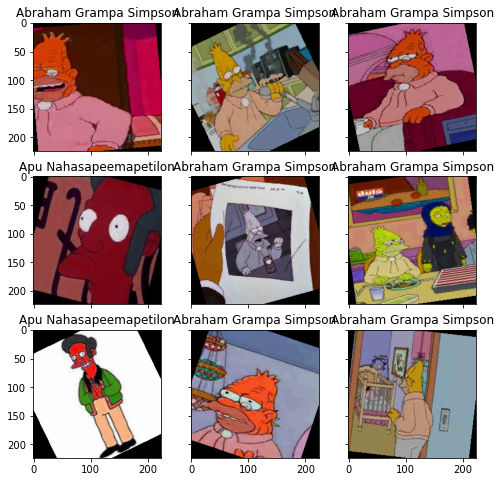

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [17]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [26]:
def fit_epoch(model, train_loader, criterion, optimizer, verbose=False):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
#     print(f"\ntrain_loader - {len(train_loader)} steps:")
    for num, (inputs, labels) in enumerate(train_loader):
        if verbose:
            print(f"{num} ", end='')

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion, verbose=False):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

#     print(f"val_loader - {len(val_loader)} steps:")
    for num, (inputs, labels) in enumerate(val_loader):
        if verbose:
            print(f"{num} ", end='')
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_dataset, val_dataset, model, epochs, batch_size, opt=None, scheduler=None, verbose=False):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = opt or torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, verbose)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion, verbose)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if scheduler:
                scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [24]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')

In [27]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64, verbose=False)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.803034407165037


epoch:  50%|█████     | 1/2 [04:26<04:26, 266.61s/it]


Epoch 001 train_loss: 2.8030     val_loss 2.1624 train_acc 0.2156 val_acc 0.4115
loss 1.8884588108449099


epoch: 100%|██████████| 2/2 [08:11<00:00, 245.83s/it]


Epoch 002 train_loss: 1.8885     val_loss 1.4862 train_acc 0.4923 val_acc 0.6028


Построим кривые обучения (завернем построение в функцию, добавим accuracy)

In [28]:
def plot_history(history):
    loss, acc, val_loss, val_acc = zip(*history)
    
    fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
    ax[0].plot(loss, label="train_loss")
    ax[0].plot(val_loss, label="val_loss")
    ax[0].legend(loc='best')
    ax[0].set_xlabel("epochs")
    ax[0].set_ylabel("loss")
    ax[0].set_title("Loss")
    
    ax[1].plot(acc, label="train_acc")
    ax[1].plot(val_acc, label="val_acc")
    ax[1].legend(loc='best')
    ax[1].set_xlabel("epochs")
    ax[1].set_ylabel("acc")
    ax[1].set_title("Accuracy")
    
    plt.show()

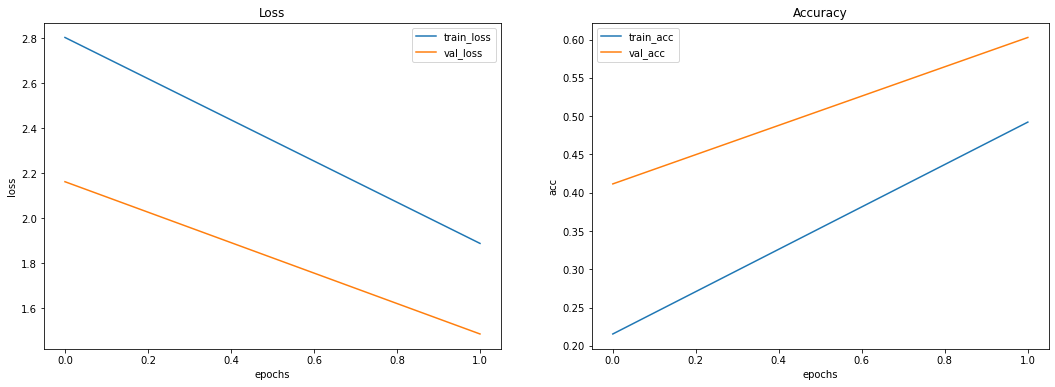

In [29]:
plot_history(history)

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [30]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

завернем подсчет **f1** для удобства в одну функцию

In [52]:
def val_f1_score(val_dataset, model, label_encoder=None, num=20):
    label_encoder = label_encoder or pickle.load(open("label_encoder.pkl", 'rb'))

    random_characters = int(np.random.uniform(0,1000))
    ex_img, true_label = val_dataset[random_characters]
    probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

    idxs = list(map(int, np.random.uniform(0,1000, num)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    y_pred = np.argmax(probs_ims,-1)

    # actual_labels = [val_dataset[id][1] for id in idxs]
    actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

    preds_class = [label_encoder.classes_[i] for i in y_pred]

    return f1_score(actual_labels, preds_class, average='micro')

In [33]:
val_f1_score(val_dataset, simple_cnn)

0.6

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [34]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

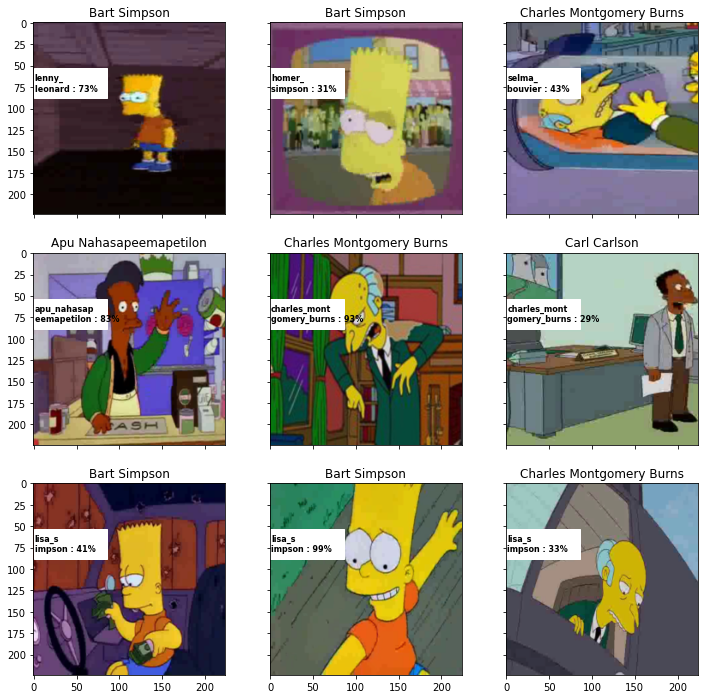

In [35]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

#### соберем подготовку submit в функцию

In [36]:
def get_save_submit(test_files, model, sub_file_name):    
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)


    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

#     sample_submission = pd.read_csv("sample_submission.csv")
#     my_submit = pd.merge(sample_submission.drop("Expected", axis=1), my_submit)

    my_submit.to_csv(sub_file_name, index=False)
    return my_submit

In [37]:
get_save_submit(test_files, simple_cnn, 'simple_cnn_baseline.csv').head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


## <center>Доработка сети

### ResNet

Ранее уже была добавлена в **SimpsonsDataset** аугментация и разные корректировки

In [38]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### создадим сеть и заморозим первые 5 блоков

In [67]:
model_extractor = models.resnet18(pretrained=True).to(DEVICE)

# # замораживаем параметры (веса)
# for param in model_extractor.parameters():
#     param.requires_grad = False

for num, child in enumerate(model_extractor.children()):
    if num < 5:
        for param in child.parameters():
            param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 512
# Заменяем Fully-Connected слой на наш линейный классификатор (здесь по дефолту веса разморожены)
model_extractor.fc = nn.Linear(num_features, n_classes).to(DEVICE)

# Обучаем только классификатор
optimizer = torch.optim.AdamW(model_extractor.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#### обучим сеть с замороженными первыми 5 блоками

In [68]:
history = train(train_dataset, val_dataset, model=model_extractor, epochs=10, 
                batch_size=64, opt=optimizer, scheduler=scheduler, verbose=False)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.1447991509901976


epoch:  10%|█         | 1/10 [03:58<35:43, 238.21s/it]


Epoch 001 train_loss: 1.1448     val_loss 0.4046 train_acc 0.7405 val_acc 0.9073
loss 0.46134931527216255


epoch:  20%|██        | 2/10 [07:57<31:48, 238.57s/it]


Epoch 002 train_loss: 0.4613     val_loss 0.3018 train_acc 0.8771 val_acc 0.9255
loss 0.2702918843984892


epoch:  30%|███       | 3/10 [11:55<27:48, 238.36s/it]


Epoch 003 train_loss: 0.2703     val_loss 0.2420 train_acc 0.9274 val_acc 0.9389
loss 0.1396358297925761


epoch:  40%|████      | 4/10 [16:00<24:01, 240.24s/it]


Epoch 004 train_loss: 0.1396     val_loss 0.1740 train_acc 0.9641 val_acc 0.9605
loss 0.1198249425248087


epoch:  50%|█████     | 5/10 [20:04<20:07, 241.57s/it]


Epoch 005 train_loss: 0.1198     val_loss 0.1711 train_acc 0.9685 val_acc 0.9608
loss 0.10584512641588756


epoch:  60%|██████    | 6/10 [24:06<16:06, 241.67s/it]


Epoch 006 train_loss: 0.1058     val_loss 0.1689 train_acc 0.9741 val_acc 0.9616
loss 0.09251768155463282


epoch:  70%|███████   | 7/10 [28:05<12:02, 240.87s/it]


Epoch 007 train_loss: 0.0925     val_loss 0.1625 train_acc 0.9770 val_acc 0.9631
loss 0.08872777448933997


epoch:  80%|████████  | 8/10 [32:03<07:59, 239.98s/it]


Epoch 008 train_loss: 0.0887     val_loss 0.1607 train_acc 0.9771 val_acc 0.9643
loss 0.08829267554426962


epoch:  90%|█████████ | 9/10 [36:01<03:59, 239.25s/it]


Epoch 009 train_loss: 0.0883     val_loss 0.1622 train_acc 0.9770 val_acc 0.9639
loss 0.08600839892954833


epoch: 100%|██████████| 10/10 [39:59<00:00, 239.91s/it]


Epoch 010 train_loss: 0.0860     val_loss 0.1612 train_acc 0.9778 val_acc 0.9645


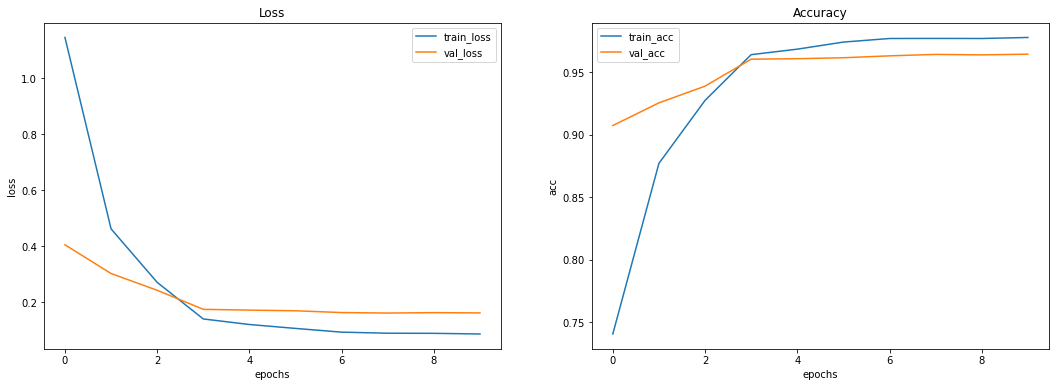

In [69]:
plot_history(history)

In [70]:
val_f1_score(val_dataset, model_extractor, num=500)

0.956

#### уже неплохо. Сохраним тестовый сабмит с этой сетки и попробуем дообучить

In [71]:
get_save_submit(test_files, model_extractor, 'resnet18_10epochs_sched.csv').head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


#### включим все слои

In [72]:
for param in model_extractor.parameters():
    param.requires_grad = True

#### доучим сеть

In [ ]:
history += train(train_dataset, val_dataset, model=model_extractor, epochs=5, 
                batch_size=64, opt=optimizer, scheduler=scheduler, verbose=False)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.08208660736677183


epoch:  20%|██        | 1/5 [04:12<16:49, 252.33s/it]


Epoch 001 train_loss: 0.0821     val_loss 0.1607 train_acc 0.9794 val_acc 0.9647
loss 0.08926075505970375


epoch:  40%|████      | 2/5 [08:09<12:23, 247.85s/it]


Epoch 002 train_loss: 0.0893     val_loss 0.1602 train_acc 0.9769 val_acc 0.9648
loss 0.086152081547648


epoch:  60%|██████    | 3/5 [12:04<08:07, 243.85s/it]


Epoch 003 train_loss: 0.0862     val_loss 0.1601 train_acc 0.9781 val_acc 0.9647
loss 0.08314068423423852


epoch:  80%|████████  | 4/5 [16:01<04:01, 241.75s/it]


Epoch 004 train_loss: 0.0831     val_loss 0.1602 train_acc 0.9789 val_acc 0.9647


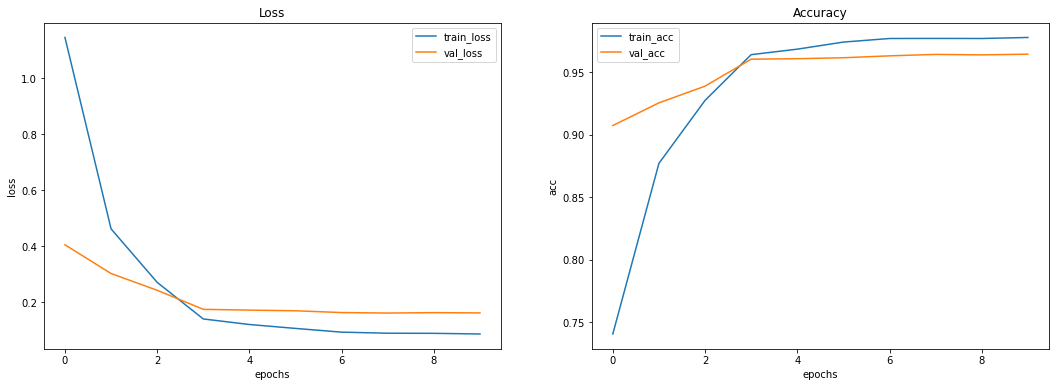

In [69]:
plot_history(history)

In [54]:
val_f1_score(val_dataset, model_extractor, num=500)

0.966

немного улучшили. Сохраним сабмит (пока финальный этот)

In [47]:
get_save_submit(test_files, model_extractor, 'resnet18_10epochs_sched_retrained.csv').head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


## Leaderboard score - 0.98618